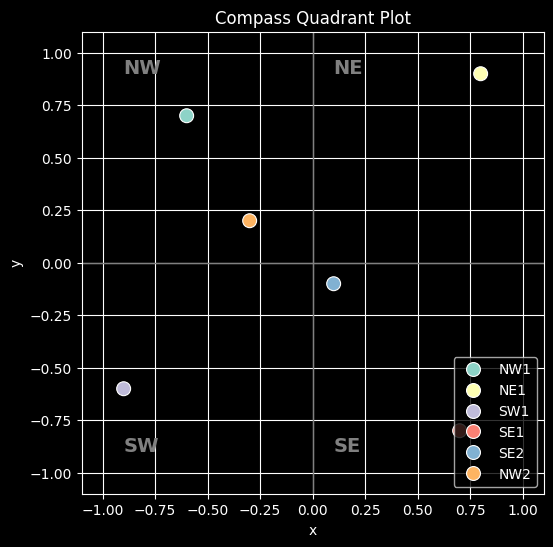

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
df = pd.DataFrame({
    'x': [-0.6, 0.8, -0.9, 0.7, 0.1, -0.3],
    'y': [0.7, 0.9, -0.6, -0.8, -0.1, 0.2],
    'label': ['NW1', 'NE1', 'SW1', 'SE1', 'SE2', 'NW2']
})

# Create the plot
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(data=df, x='x', y='y', hue='label', s=100)

# Add vertical and horizontal lines to create quadrants
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)

# Add quadrant labels
offset = 0.1
plt.text(-1 + offset, 1 - offset, 'NW', fontsize=14, weight='bold', color='gray')
plt.text(0 + offset, 1 - offset, 'NE', fontsize=14, weight='bold', color='gray')
plt.text(-1 + offset, -1 + offset, 'SW', fontsize=14, weight='bold', color='gray')
plt.text(0 + offset, -1 + offset, 'SE', fontsize=14, weight='bold', color='gray')

# Tweak layout
plt.title("Compass Quadrant Plot")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()
